In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import math
from scipy import stats
from scipy.stats import norm
from scipy.special import softmax
from sklearn.metrics import classification_report
import plotly.graph_objects as grp
from  dataclasses import dataclass
import keras
from sklearn.preprocessing import OneHotEncoder
from scipy import optimize
from sklearn.metrics import multilabel_confusion_matrix
import plotly.subplots as sp
import plotly.graph_objects as go
import missingno as msno
from pandas.core.common import random_state
from scipy import optimize
from sklearn import svm
from scipy.optimize import Bounds, minimize
from os import supports_effective_ids

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

In [4]:
bank_df=bank_marketing.data.original
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


# EDA

I. Data Structure

In [5]:
bank_df.shape

(45211, 17)

In [6]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
bank_df.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [8]:
bank_df.dtypes

age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

In [9]:
#percentage of null values in each feature
bank_df.isna().mean().round(4) * 100

age             0.00
job             0.64
marital         0.00
education       4.11
default         0.00
balance         0.00
housing         0.00
loan            0.00
contact        28.80
day_of_week     0.00
month           0.00
duration        0.00
campaign        0.00
pdays           0.00
previous        0.00
poutcome       81.75
y               0.00
dtype: float64

In [10]:
#checking for duplicate rows if any
bank_df.duplicated().sum()

0

II. Null Values

In [11]:
bank_df.isna().mean().round(4) * 100

age             0.00
job             0.64
marital         0.00
education       4.11
default         0.00
balance         0.00
housing         0.00
loan            0.00
contact        28.80
day_of_week     0.00
month           0.00
duration        0.00
campaign        0.00
pdays           0.00
previous        0.00
poutcome       81.75
y               0.00
dtype: float64

**i. variable poutcome:** Dropping poutcome feature since more that 81% of the values are null, and it would be meaningless to fill it by imputation



In [12]:
# dropping poutcome feature
bank_df.drop(columns=['poutcome'], inplace=True)

**ii. variables Job and Education:** Filling null values by mode imputation

In [13]:
job_mode=bank_df['job'].mode().values[0]
bank_df['job'].fillna(job_mode, inplace=True) #filled na in job with it's mode 'blue-collar'
education_mode=bank_df['education'].mode().values[0]
bank_df['education'].fillna(education_mode, inplace=True) #filled education column with it's mode

**iii. variable contact:** Creating a new category 'unknown' with all the null values

In [14]:
#since 28% of contact is null we are creating a seperate category called unknown
bank_df['contact'].fillna('unknown', inplace=True)
bank_df['contact'].value_counts()

contact
cellular     29285
unknown      13020
telephone     2906
Name: count, dtype: int64

**III. Duration:**  
The variable duration has the duration of the last contact, in seconds (numeric).Important note given by dataset: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.



In [15]:
bank_df.drop(columns=['duration'], inplace=True)
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,no
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,1,-1,0,no
4,33,blue-collar,single,secondary,no,1,no,no,unknown,5,may,1,-1,0,no


IV. Data Visualization

i. target variable y:

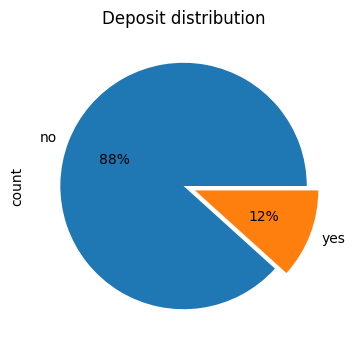

In [16]:
#target values
plt.figure(figsize=(4,4))
bank_df['y'].value_counts().plot(kind='pie', autopct='%1.0f%%', explode=(0, 0.1))
plt.title('Deposit distribution')
plt.show()

Contact and deposit subscription status

In [17]:
bank_df['contact'].value_counts(normalize=True)

contact
cellular     0.647741
unknown      0.287983
telephone    0.064276
Name: proportion, dtype: float64

<Axes: xlabel='contact', ylabel='count'>

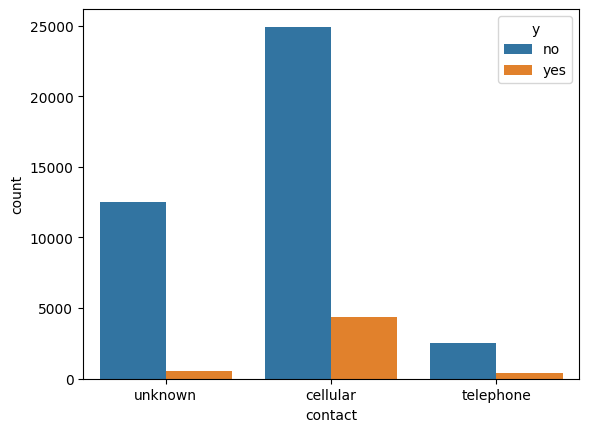

In [18]:
sns.countplot(bank_df, x="contact", hue='y')

Housing and deposit subscription status

<Axes: xlabel='housing', ylabel='count'>

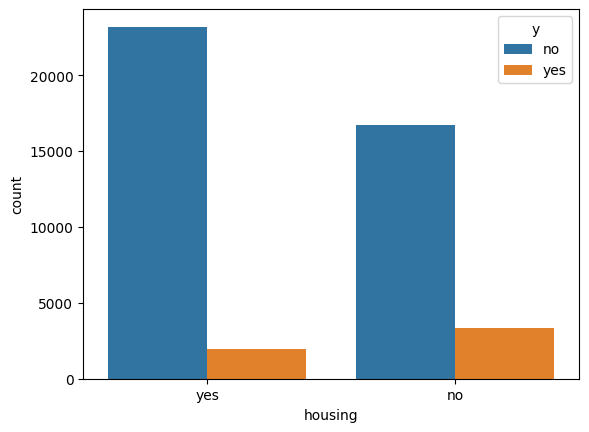

In [19]:
sns.countplot(bank_df, x="housing", hue="y")

Loan and deposit subscription status

<Axes: xlabel='loan', ylabel='count'>

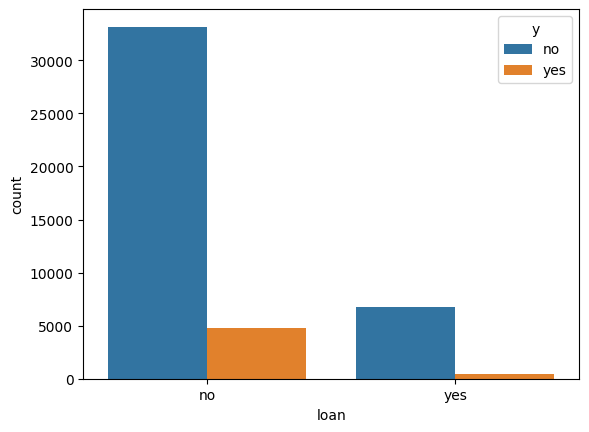

In [20]:
sns.countplot(bank_df, x="loan", hue="y")

Default and deposit subscription status


<Axes: xlabel='default', ylabel='proportion'>

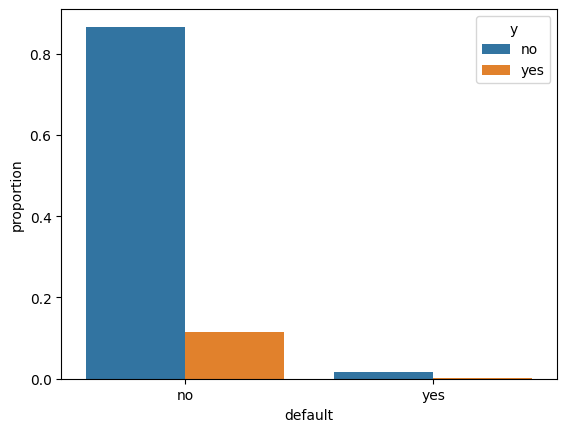

In [21]:
sns.countplot(bank_df, x="default", hue="y",stat='proportion')

Month wise deposit subscription status

In [22]:
bank_df['month'].value_counts(normalize=True)

month
may    0.304483
jul    0.152507
aug    0.138174
jun    0.118135
nov    0.087810
apr    0.064851
feb    0.058592
jan    0.031032
oct    0.016323
sep    0.012807
mar    0.010551
dec    0.004733
Name: proportion, dtype: float64

<Axes: xlabel='month', ylabel='count'>

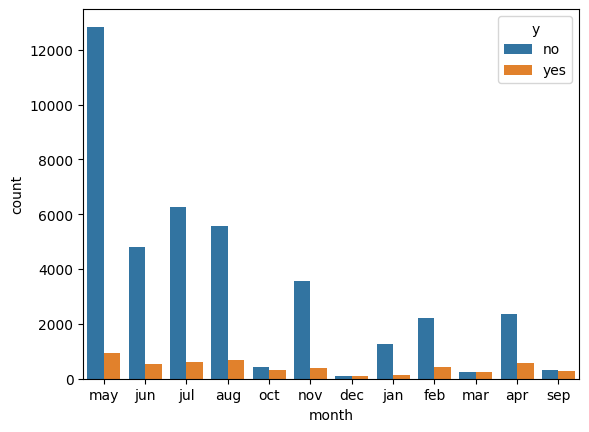

In [23]:
sns.countplot(bank_df, x="month", hue="y")

Age distribution among Customers

In [24]:
bank_df['age'].describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

<Axes: xlabel='age', ylabel='Count'>

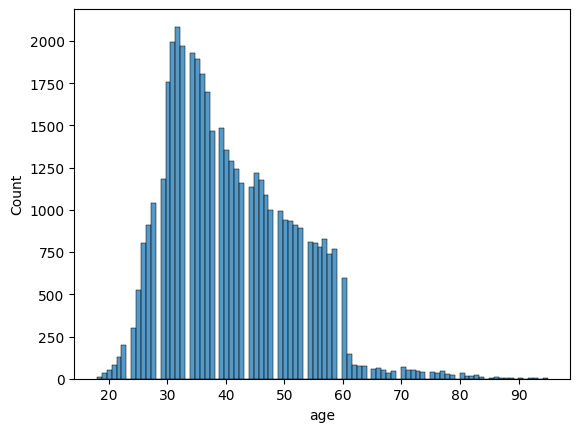

In [25]:
#distribution of age
sns.histplot(data=bank_df, x="age")

Job distribution among Customers

In [26]:
bank_df['job'].value_counts()

job
blue-collar      10020
management        9458
technician        7597
admin.            5171
services          4154
retired           2264
self-employed     1579
entrepreneur      1487
unemployed        1303
housemaid         1240
student            938
Name: count, dtype: int64

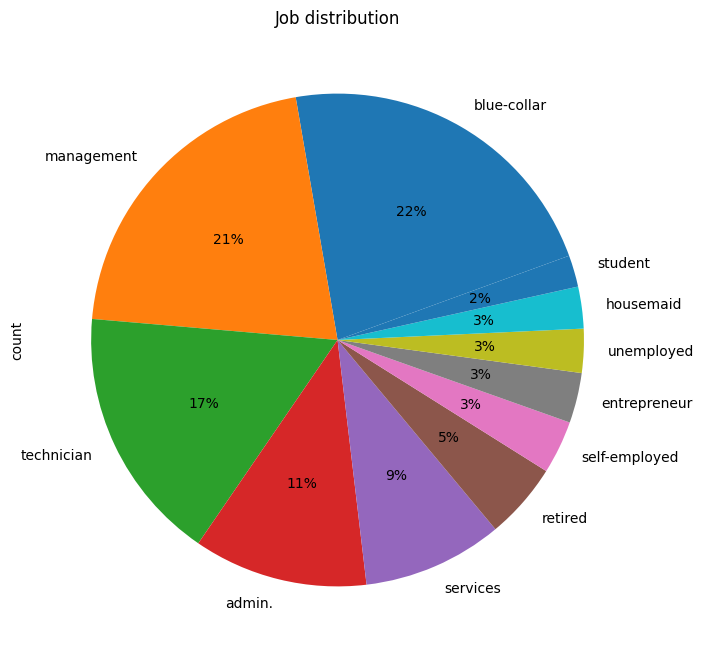

In [27]:
plt.figure(figsize=(8, 8))
bank_df['job'].value_counts().plot(kind='pie', autopct='%1.0f%%', startangle=20)
plt.title('Job distribution')
plt.show()

Marital Status distribution among Customers

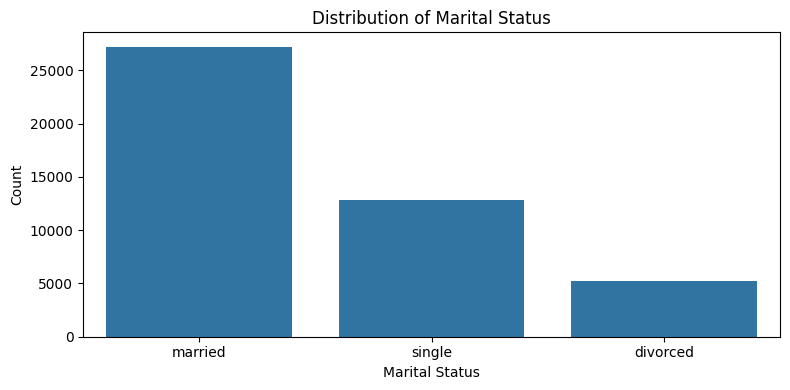

In [28]:
plt.figure(figsize=(8,4))
sns.countplot(bank_df, x="marital")
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Distribution of Marital Status')
plt.tight_layout()
plt.show()

Education level distribution among Customers


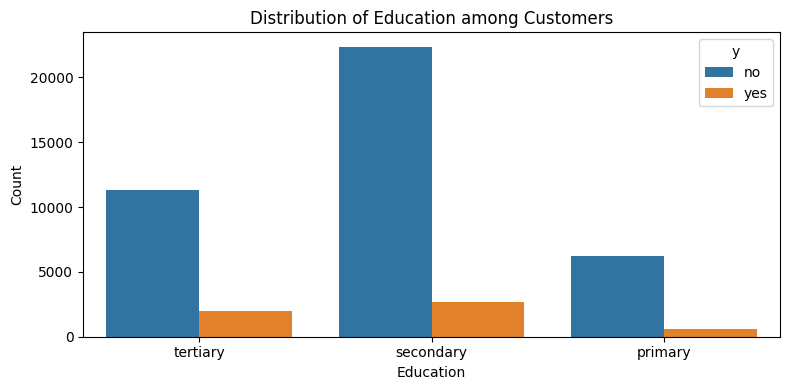

In [29]:
plt.figure(figsize=(8,4))
sns.countplot(bank_df, x="education", hue='y')
plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Distribution of Education among Customers')
plt.tight_layout()
plt.show()

Correlation between numerical variables

In [30]:
numerical_features = bank_df.select_dtypes(include=['int64', 'float64']).columns
numerical_features

Index(['age', 'balance', 'day_of_week', 'campaign', 'pdays', 'previous'], dtype='object')

In [31]:
categorical_features = bank_df.select_dtypes(include=['object']).columns
categorical_features

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'y'],
      dtype='object')

In [32]:
corr= bank_df[numerical_features].corr()
corr

,age,balance,day_of_week,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,-0.014578,0.003435,0.016674
day_of_week,-0.009120,0.004503,1.000000,0.162490,-0.093044,-0.051710
campaign,0.004760,-0.014578,0.162490,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,-0.032855,0.454820,1.000000


Heatmap of correlation between numerical variables

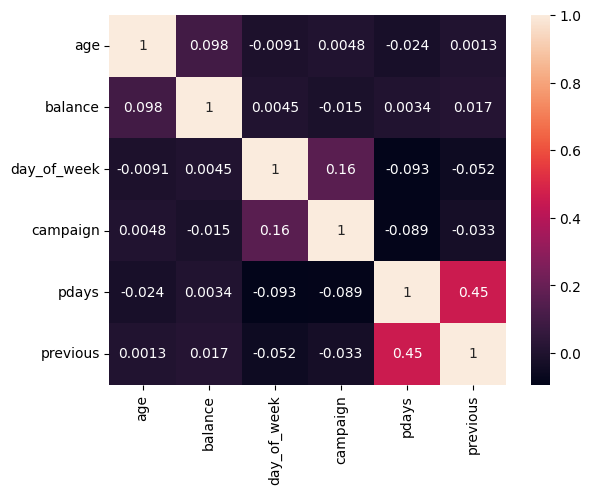

In [33]:
sns.heatmap(corr, annot=True)
plt.show()

low correlation between pdays and previous

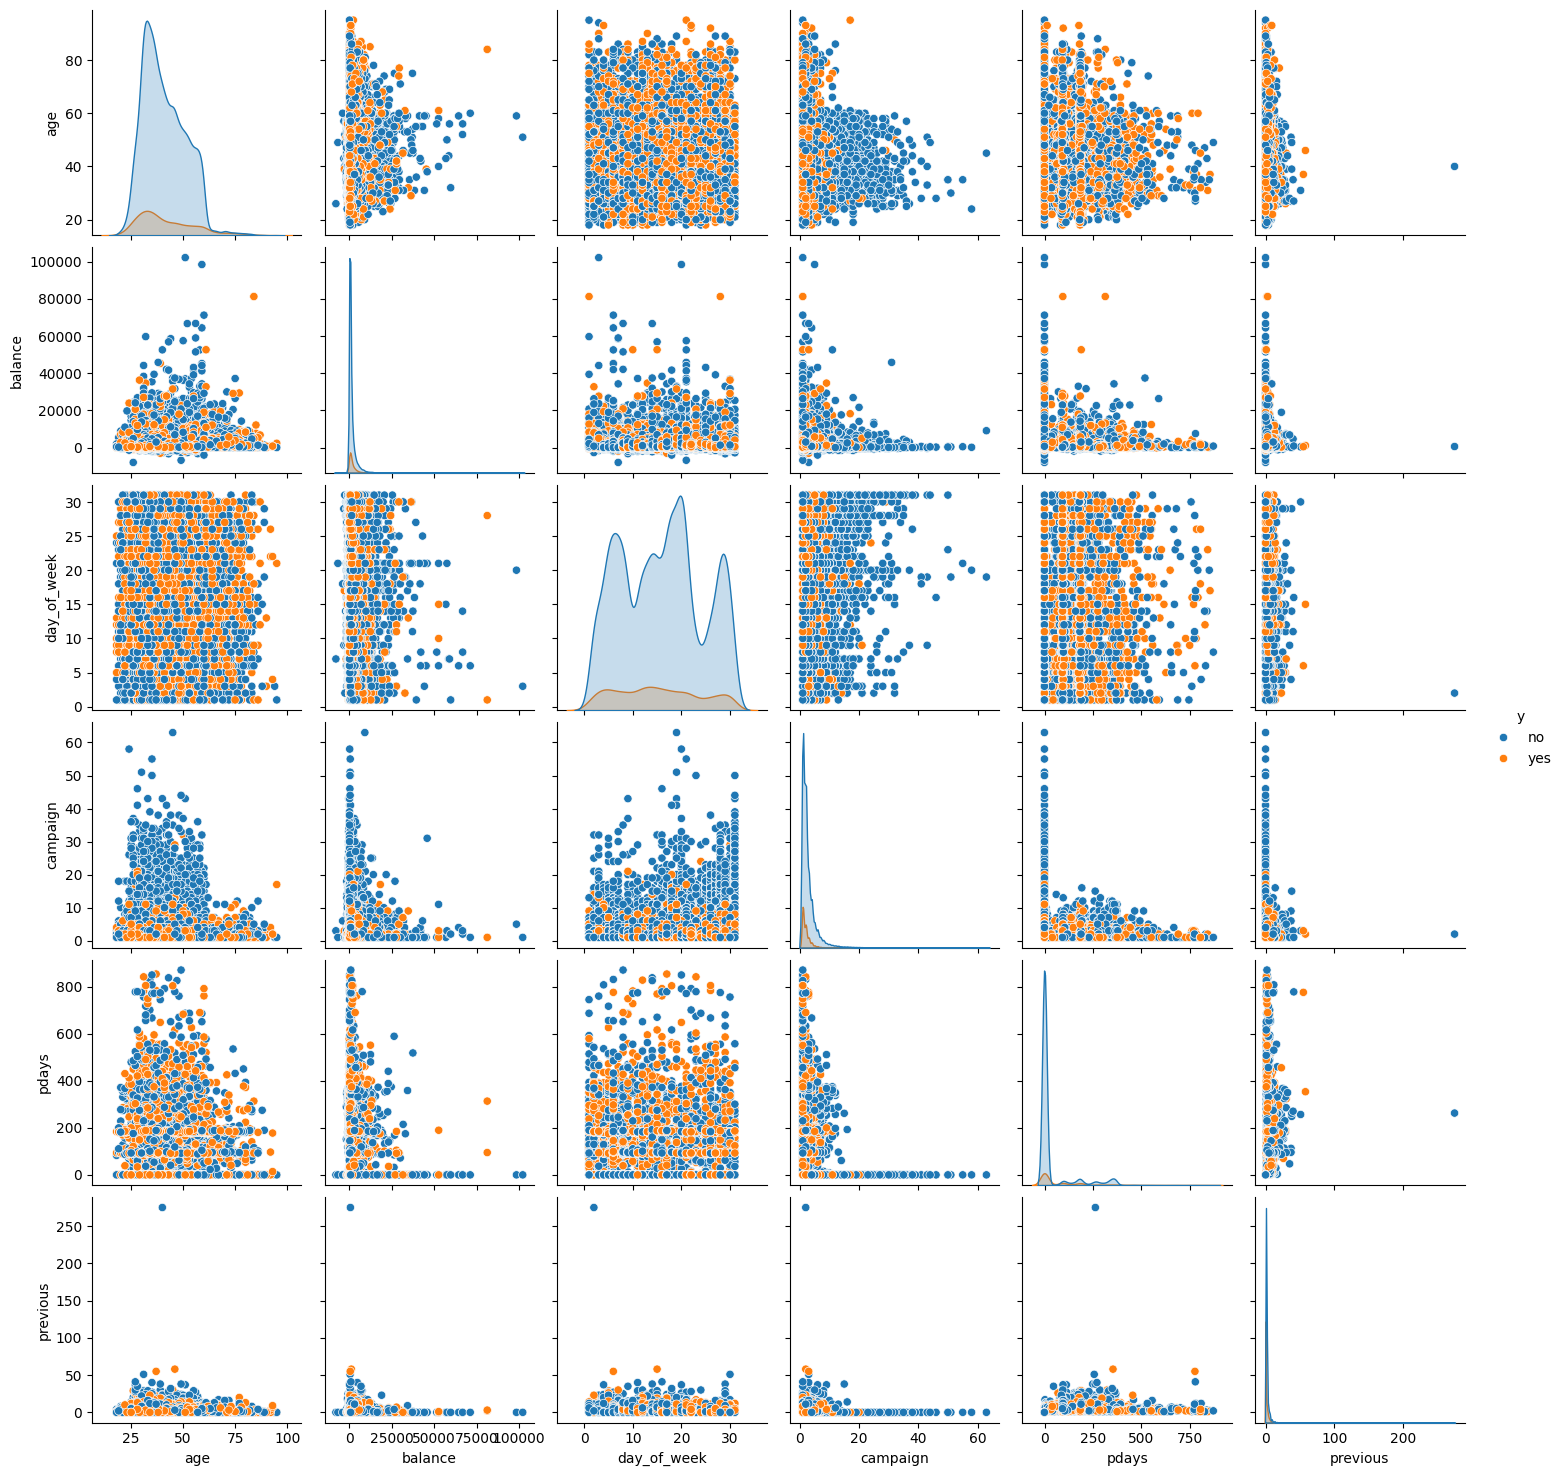

In [35]:
sns.pairplot(bank_df, hue='y')

# Feature Engineering

i. Outliers

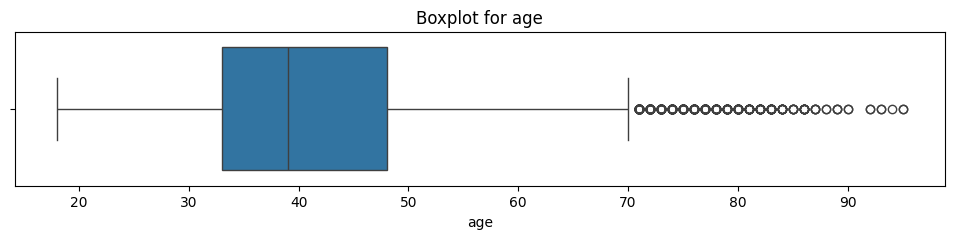

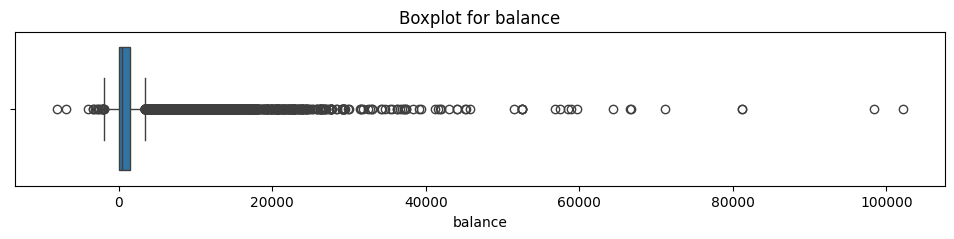

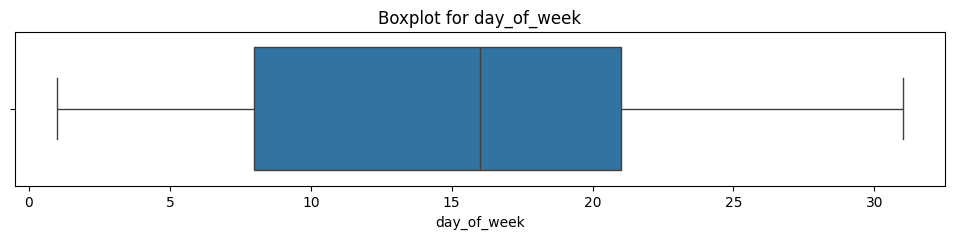

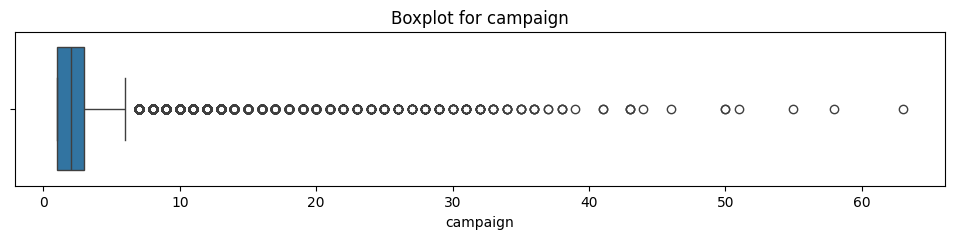

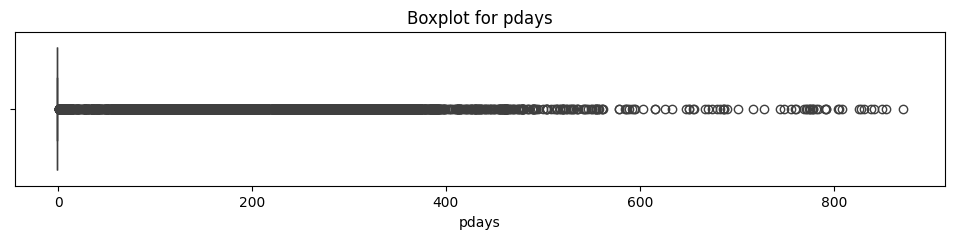

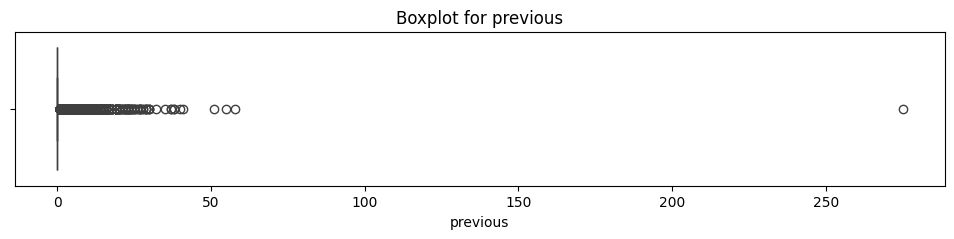

In [37]:
for i in numerical_features:
  plt.figure(figsize=(12,2))
  sns.boxplot(data = bank_df, x = i)
  plt.title('Boxplot for {}'.format(i))

In [38]:
def remove_outliers(df, feature):
  high_threshold = df[feature].quantile(0.99)
  print("99th percentile:", high_threshold, 'of feature', feature)
  df = df[df[feature] <= high_threshold]
  return df

In [39]:
bank_df

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,no
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,1,-1,0,no
4,33,blue-collar,single,secondary,no,1,no,no,unknown,5,may,1,-1,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,no


In [40]:
df = remove_outliers(bank_df, 'campaign')
df = remove_outliers(df, 'previous')
df.describe()

99th percentile: 16.0 of feature campaign
99th percentile: 9.0 of feature previous


,age,balance,day_of_week,campaign,pdays,previous
count,44399.000000,44399.000000,44399.000000,44399.000000,44399.000000,44399.000000
mean,40.947792,1361.807901,15.747337,2.553594,39.128291,0.462128
std,10.620780,3045.761181,8.298146,2.224303,98.981867,1.261160
min,18.000000,-8019.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,73.000000,8.000000,1.000000,-1.000000,0.000000
50%,39.000000,450.000000,16.000000,2.000000,-1.000000,0.000000
75%,48.000000,1424.500000,21.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,16.000000,871.000000,9.000000


ii. pdays

In [41]:
df['pdays'].describe() #pdays have values with -1, which represents no calls made.

count    44399.000000
mean        39.128291
std         98.981867
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

In [42]:
df['pdays'].replace(-1, 0, inplace=True) #replaced -1 with 0
df['pdays'].describe()

count    44399.000000
mean        39.950449
std         98.648726
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        871.000000
Name: pdays, dtype: float64

iii. Binning

In [43]:
bins=[0,20,30,40,50,60,70,80,100] #binning ages
labels=['<20', '20-30','30-40','40-50','50-60','60-70','70-80','80<']
df['age_category']=pd.cut(df['age'], bins=bins, labels=labels, right=False)
df

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,y,age_category
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,0,0,no,50-60
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,0,0,no,40-50
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,0,0,no,30-40
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,1,0,0,no,40-50
4,33,blue-collar,single,secondary,no,1,no,no,unknown,5,may,1,0,0,no,30-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,2,0,0,yes,20-30
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,0,0,yes,50-60
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,0,0,yes,70-80
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,yes,70-80


iv. Target Encoding

In [44]:
# @title
label_encoder = LabelEncoder()

In [45]:
df['y'] = label_encoder.fit_transform(df['y'])
df['default']=label_encoder.fit_transform(df['default'])
df["housing"]=label_encoder.fit_transform(df['housing'])
df["loan"]=label_encoder.fit_transform(df['loan'])
df

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,y,age_category
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,0,0,0,50-60
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,0,0,0,40-50
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,0,0,0,30-40
3,47,blue-collar,married,secondary,0,1506,1,0,unknown,5,may,1,0,0,0,40-50
4,33,blue-collar,single,secondary,0,1,0,0,unknown,5,may,1,0,0,0,30-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45205,25,technician,single,secondary,0,505,0,1,cellular,17,nov,2,0,0,1,20-30
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,3,0,0,1,50-60
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,2,0,0,1,70-80
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,5,184,3,1,70-80


In [46]:
#target encoding job
df["job_encoded"] = df.groupby("job")["y"].transform("mean")
#target encoding education
df["education_encoded"] = df.groupby("education")["y"].transform("mean")
#target encoding contact
df["contact_encoded"] = df.groupby("contact")["y"].transform("mean")
#target encoding marital status
df["marital_encoded"] = df.groupby("marital")["y"].transform("mean")
#target encoding month
df["month_encoded"] = df.groupby("month")["y"].transform("mean")
#target encoding Age_category
df["age_encoded"] = df.groupby("age_category")["y"].transform("mean")

In [47]:
num_features= ['age_encoded', 'job_encoded',	'education_encoded',	'contact_encoded', 'marital_encoded',	'month_encoded', 'default',	'balance',	'housing',	'loan',	'day_of_week',	'campaign',	'pdays',	'previous',	'y']

In [48]:
df_num=df[num_features]
df_num

,age_encoded,job_encoded,education_encoded,contact_encoded,marital_encoded,month_encoded,default,balance,housing,loan,day_of_week,campaign,pdays,previous,y
0,0.093501,0.137890,0.150660,0.041058,0.101343,0.067083,0,2143,1,0,5,1,0,0,0
1,0.091449,0.111022,0.107847,0.041058,0.149581,0.067083,0,29,1,0,5,1,0,0,0
2,0.106096,0.081522,0.107847,0.041058,0.101343,0.067083,0,2,1,1,5,1,0,0,0
3,0.091449,0.074394,0.107847,0.041058,0.101343,0.067083,0,1506,1,0,5,1,0,0,0
4,0.106096,0.074394,0.107847,0.041058,0.149581,0.067083,0,1,0,0,5,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45205,0.173591,0.111022,0.107847,0.149382,0.149581,0.101069,0,505,0,1,17,2,0,0,1
45206,0.093501,0.111022,0.150660,0.149382,0.101343,0.101069,0,825,0,0,17,3,0,0,1
45207,0.424460,0.226786,0.085753,0.149382,0.119656,0.101069,0,1729,0,0,17,2,0,0,1
45208,0.424460,0.226786,0.107847,0.149382,0.101343,0.101069,0,5715,0,0,17,5,184,3,1


# Logistic Regression without PCA

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

class LogisticRegressionClass:
    def __init__(self, data, learning_rate=0.00005, epsilon=1e-8, max_iterations=1000, reg_type=None, reg_lambda=0, print_log=False, remove_index=[], fit_intercept=True):
        self.data = data
        self.fit_intercept = fit_intercept
        self.data=data
        self.remove_index = remove_index
        self.reg_type = reg_type
        self.reg_lambda = reg_lambda if reg_type else 0

        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        self.print_log = print_log

    def data_reader(self, data):
        X=self.data.drop(columns=['y'], axis=1)
        y=self.data['y']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=23, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23, stratify=y_train)
        return X_train, X_test, X_val, y_train, y_test, y_val

    def standarize_data(self, X_train, X_test, X_val):
      mean=X_train.mean()
      std=X_train.std()
      X_train = (X_train - mean) / std
      X_test = (X_test - mean) / std
      X_val = (X_val - mean) / std

      return X_train, X_test, X_val

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z.astype(float)))

    def add_x0(self, X):
      if self.fit_intercept:
        return np.column_stack([np.ones(X.shape[0]), X])
      return X

    def multiply(self, X):
        return np.matmul(X, self.weight)

    def predict(self, X, cutoff = 0.5):
        sol = self.sigmoid(np.matmul(X, self.weight))
        return (sol > cutoff).astype(int)

    def loss_functions(self, X, y):
        y_hat = self.multiply(X)
        p = self.sigmoid(y_hat)
        #return -1 - np.dot(y, y_hat) + (self.sigmoid(y_hat)).sum()
        return -(np.matmul(y, np.log(p)) + np.matmul(1-y, np.log(1-p)))

    def derivative_loss_functions(self, X, y):
        y_hat = self.multiply(X)
        return np.matmul(X.T, (self.sigmoid(y_hat) - y))

    def reg_functions(self):
        if self.reg_type == "L2":
            return ((self.weight) ** 2).sum()

        if self.reg_type == "L1":
            return (abs(self.weight)).sum()
        else:
            return 0
    def derivative_reg_functions(self):

        if self.reg_type == "L2":
            return 2* self.weight

        if self.reg_type == "L1":
            return np.sign(self.weight)

        else:
            return 0

    def gradient_descent(self, X_train, y_train, X_val, y_val):
        train_costs = []
        val_costs = []
        iterations = []
        previous_cost = math.inf
        for iter in tqdm(range(1, self.max_iterations)):

            step = self.learning_rate * (self.derivative_loss_functions(X_train, y_train) + self.reg_lambda * self.derivative_reg_functions())

            self.weight = self.weight - step

            train_current_cost = self.loss_functions(X_train, y_train) + self.reg_lambda * self.reg_functions()
            val_current_cost = self.loss_functions(X_val, y_val) + self.reg_lambda * self.reg_functions()
            #print(current_cost)
            train_costs.append(train_current_cost)
            val_costs.append(val_current_cost)
            iterations.append(iter)

            if self.print_log:
                print("Step : " + str(iter) + ": ","\n")
                print("\t" + "change ",step, "\n")
                print("current_weights: ", self.weight)
                print("current_cost: ", train_current_cost)
                print("current_cost_change: ", abs(train_current_cost - previous_cost), "\n")

            if abs(train_current_cost - previous_cost) < self.epsilon:
                print("Done")
                break
            previous_cost = train_current_cost
        print("train cost trend")
        self.fig_plot(iterations,train_costs)
        print("validation cost trend")
        self.fig_plot(iterations,val_costs)

    def evaluation_metrics(self, y, y_pred):

        print("Training metrics")
        self.confusion_matrix(y, y_pred)

    def confusion_matrix(self, y, y_pred):

        a1_p1 = np.sum((y & y_pred))
        a1_p0 = y.sum() - a1_p1

        a0_p1 = y_pred.sum() - a1_p1
        a0_p0 = len(y) - y.sum() - a0_p1

        matrix = np.array([[a0_p0, a0_p1], [a1_p0, a1_p1]])

        plt.figure(figsize=(10,6))
        sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")

        ## Metrics
        Accuracy = (a1_p1 + a0_p0)/ len(y)
        Error_rate = 1 - Accuracy

        Sensitivity = a1_p1/y.sum()
        False_Negative_Rate = 1 - Sensitivity

        Specificity = a0_p0/(len(y) - y.sum())

        F1_score = 2 * Sensitivity * Specificity/(Sensitivity + Specificity)

        metrics_df = pd.DataFrame({ "Metrics": ["Accuracy", "Error rate", "Sensitivity/Recall/True Positive Rate",
                                                "False Negative Rate", "Specificity/True Negative Rate", "F1 score"
                                               ],
                                   "Values": [Accuracy, Error_rate, Sensitivity, False_Negative_Rate,
                                             Specificity, F1_score
                                             ]

        })
        metrics_df.set_index("Metrics", inplace = True)
        display(metrics_df)

    def fig_plot(self, iters, costs):
        plt.plot(costs)
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        plt.title("Cost vs iteration")
        plt.show()

    # def fig_plot(self, x_data, y_data):
    #     sns.lineplot(x= x_data, y= y_data)


    # def plot(self):
    #     plt.figure(figsize=(14,12))
    #     ax = plt.axes(projection='3d')

    #     # Data for three-dimensional scattered points
    #     if self.fit_intercept:
    #         _add = 1
    #     else:
    #         _add = 0
    #     ax.scatter3D(self.X[:, 0 + _add], self.X[:, 1 + _add],
    #                  self.sigmoid(np.matmul(self.X, self.weight)),
    #                  c = self.y, cmap='viridis', s=100);

    #     #ax.set_xlim3d(55, 80)
    #     #ax.set_ylim3d(80, 240)
    #     plt.xlabel('$x_1$ feature', fontsize=15)
    #     plt.ylabel('$x_2$ feature', fontsize=15, )
    #     ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)

    def predict_proba(self, X):
      # Ensure that the input features and the weights have compatible shapes
      if self.fit_intercept and (X.shape[1] + 1 == len(self.weight)):
        # If fit_intercept is True and the intercept is not in X, add it
        X = self.add_x0(X)
      elif not self.fit_intercept and (X.shape[1] == len(self.weight)):
        # If fit_intercept is False and X already has the intercept term, remove it
        X = X[:, 1:]
      return self.sigmoid(np.matmul(X, self.weight))

  #  # Create the 3D plot
  #     fig = plt.figure()
  #     ax = fig.add_subplot(111, projection='3d')
  #     x1_feature = X_test.iloc[:, 0]
  #     x2_feature = X_test.iloc[:, 1]
  #     ax.scatter(x1_feature, x2_feature, probs, c=probs, cmap='viridis', marker='o')
  #     ax.set_xlabel('x1 feature')
  #     ax.set_ylabel('x2 feature')
  #     ax.set_zlabel('Probability')
  #     plt.show()

    def standarize_single_data(self, X):
      mean = X.mean()
      std = X.std()
      X_standardized = (X - mean) / std
      return X_standardized

    def fit(self):
    # Data reading and preprocessing
      X_train, X_test, X_val, y_train, y_test, y_val = self.data_reader(self.data)

    # Apply SMOTE to the training data to handle class imbalance
      smote = SMOTE(random_state=23)
      X_train, y_train = smote.fit_resample(X_train, y_train)

    # Continue as before...
      X_train, X_test, X_val = self.standarize_data(X_train, X_test, X_val)

    # Add the intercept term
      X_train = self.add_x0(X_train)
      X_test = self.add_x0(X_test)
      X_val = self.add_x0(X_val)

    # Storing standardized data for model training
      self.X_train, self.X_test, self.X_val = X_train, X_test, X_val
      self.y_train, self.y_test, self.y_val = y_train, y_test, y_val

    # Initialize weight vector with correct dimensions
      num_features = X_train.shape[1]
      self.weight = np.zeros(num_features)

    # Weight initialization and gradient descent
      self.gradient_descent(X_train, y_train, X_val, y_val)

      print("Gradient descent completed")

    # Find the best threshold for validation set
      best_threshold, best_f1 = self.find_best_threshold(X_val, y_val)

      print(f"Best threshold: {best_threshold}, Best F1 score on validation: {best_f1}")

    # Use the best threshold to predict on the test set
      y_pred = (self.predict_proba(X_test) > best_threshold).astype(int)
      self.evaluation_metrics(y_test, y_pred)



    def find_best_threshold(self, X_val, y_val):
      best_threshold = 0.5
      best_f1 = 0
      thresholds = np.linspace(0.01, 0.99, 100)
      for threshold in thresholds:
        y_pred = (self.predict_proba(X_val) > threshold).astype(int)
        current_f1 = f1_score(y_val, y_pred)
        if current_f1 > best_f1:
          best_f1 = current_f1
          best_threshold = threshold
      return best_threshold, best_f1



 17%|█▋        | 172/999 [00:02<00:09, 83.21it/s] 


Done
train cost trend


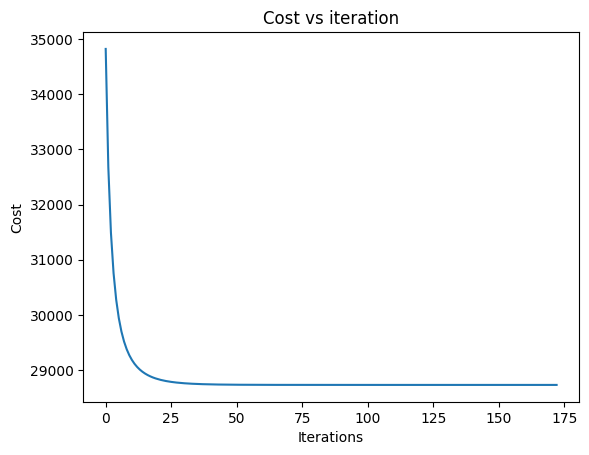

validation cost trend


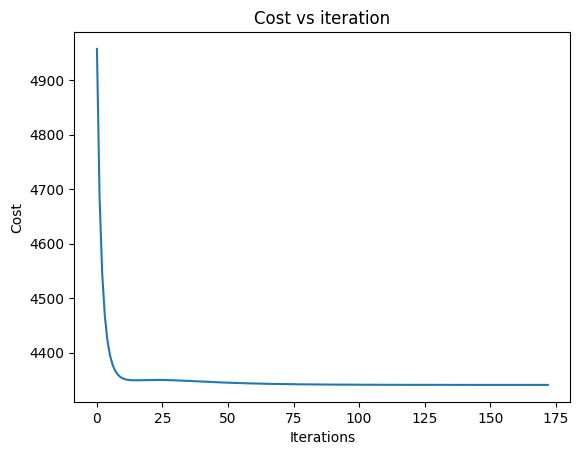

Gradient descent completed
Best threshold: 0.693030303030303, Best F1 score on validation: 0.3910939012584705
Training metrics


,Values
Metrics,
Accuracy,0.845495
Error rate,0.154505
Sensitivity/Recall/True Positive Rate,0.415385
False Negative Rate,0.584615
Specificity/True Negative Rate,0.902551
F1 score,0.568929


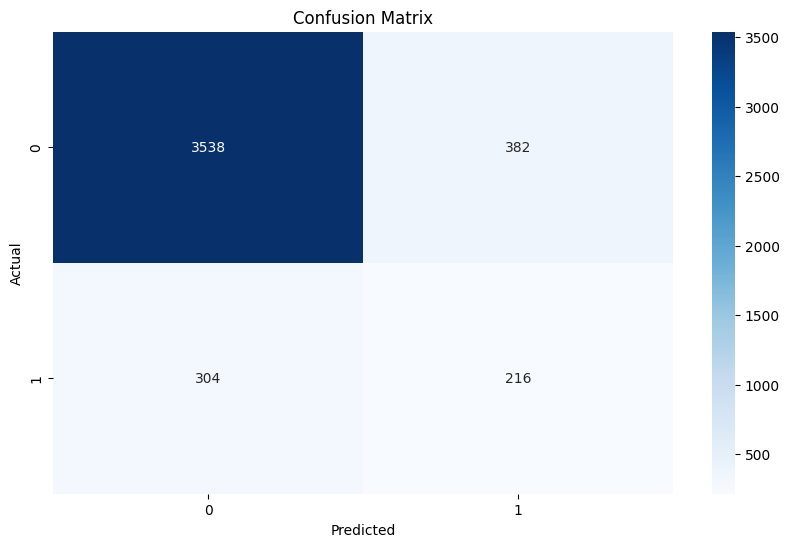

In [50]:
solver = LogisticRegressionClass(data=df_num, learning_rate=1e-5,
                                 epsilon=1e-5, max_iterations=1000)
solver.fit()

# Logistic regression with PCA

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import math
from IPython.display import display

class LogisticRegressionClass_PCA:
    def __init__(self, data, learning_rate=0.00005, epsilon=1e-8,
                 max_iterations=1000, reg_type=None, reg_lambda=0, print_log=False, n_component=None) -> None:
        self.data = data
        self.reg_type = reg_type
        self.reg_lambda = reg_lambda if reg_type else 0
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.n_component = n_component
        self.max_iterations = max_iterations
        self.print_log = print_log
        self.weight = None

    def data_reader(self, data):
        X = self.data.drop(columns=['y'], axis=1)
        y = self.data['y']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=23, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23, stratify=y_train)
        return X_train, X_test, X_val, y_train, y_test, y_val

    def standarize_data(self, X_train, X_test, X_val):
        mean = X_train.mean()
        std = X_train.std()
        X_train = (X_train - mean) / std
        X_test = (X_test - mean) / std
        X_val = (X_val - mean) / std
        return X_train, X_test, X_val

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z.astype(float)))

    def add_x0(self, X):
        return np.column_stack([np.ones(X.shape[0]), X])

    def multiply(self, X):
        return np.matmul(X, self.weight)

    def predict(self, X, cutoff=0.5):
        sol = self.sigmoid(np.matmul(X, self.weight))
        return (sol > cutoff).astype(int)

    def loss_functions(self, X, y):
        y_hat = self.multiply(X)
        p = self.sigmoid(y_hat)
        return -(np.matmul(y, np.log(p)) + np.matmul(1 - y, np.log(1 - p)))

    def derivative_loss_functions(self, X, y):
        y_hat = self.multiply(X)
        return np.matmul(X.T, (self.sigmoid(y_hat) - y))

    def reg_functions(self):
        if self.reg_type == "L2":
            return ((self.weight) ** 2).sum()
        elif self.reg_type == "L1":
            return (abs(self.weight)).sum()
        else:
            return 0

    def derivative_reg_functions(self):
        if self.reg_type == "L2":
            return 2 * self.weight
        elif self.reg_type == "L1":
            return np.sign(self.weight)
        else:
            return 0

    def gradient_descent(self, X_train, y_train, X_val, y_val):
        train_costs = []
        val_costs = []
        iterations = []
        previous_cost = math.inf
        for iter in tqdm(range(1, self.max_iterations)):
            step = self.learning_rate * (self.derivative_loss_functions(X_train, y_train) + self.reg_lambda * self.derivative_reg_functions())
            self.weight = self.weight - step
            train_current_cost = self.loss_functions(X_train, y_train) + self.reg_lambda * self.reg_functions()
            val_current_cost = self.loss_functions(X_val, y_val) + self.reg_lambda * self.reg_functions()
            train_costs.append(train_current_cost)
            val_costs.append(val_current_cost)
            iterations.append(iter)
            if self.print_log:
                print("Step : " + str(iter) + ": ")
                print("\tChange: ", step)
                print("Current weights: ", self.weight)
                print("Current cost: ", train_current_cost)
                print("Cost change: ", abs(train_current_cost - previous_cost))
            if abs(train_current_cost - previous_cost) < self.epsilon:
                print("Done")
                break
            previous_cost = train_current_cost

    def evaluation_metrics(self, y, y_pred):
        print("Training metrics")
        self.confusion_matrix(y, y_pred)

    def confusion_matrix(self, y, y_pred):
        a1_p1 = np.sum((y & y_pred))
        a1_p0 = y.sum() - a1_p1
        a0_p1 = y_pred.sum() - a1_p1
        a0_p0 = len(y) - y.sum() - a0_p1
        matrix = np.array([[a0_p0, a0_p1], [a1_p0, a1_p1]])
        plt.figure(figsize=(10, 6))
        sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        Accuracy = (a1_p1 + a0_p0) / len(y)
        Error_rate = 1 - Accuracy
        Sensitivity = a1_p1 / y.sum()
        False_Negative_Rate = 1 - Sensitivity
        Specificity = a0_p0 / (len(y) - y.sum())
        F1_score = 2 * Sensitivity * Specificity / (Sensitivity + Specificity)
        metrics_df = pd.DataFrame({
            "Metrics": ["Accuracy", "Error rate", "Sensitivity/Recall/True Positive Rate",
                        "False Negative Rate", "Specificity/True Negative Rate", "F1 score"],
            "Values": [Accuracy, Error_rate, Sensitivity, False_Negative_Rate,
                       Specificity, F1_score]
        })
        metrics_df.set_index("Metrics", inplace=True)
        display(metrics_df)

    def predict_proba(self, X):
      """
      Compute the probability estimates for the positive class.
      """
      z = self.multiply(X)  # Calculate the linear combination of weights and features
      return self.sigmoid(z)  # Apply the sigmoid function to get probabilities


    def apply_pca(self, X_train, X_val, X_test, n_components):
      pca = PCA(n_components=n_components)
      X_train_pca = pca.fit_transform(X_train)
      X_val_pca = pca.transform(X_val)
      X_test_pca = pca.transform(X_test)
    # Check the shape of the PCA components
      print(f"PCA components shape (train): {X_train_pca.shape}")
      print(f"PCA components shape (val): {X_val_pca.shape}")
      print(f"PCA components shape (test): {X_test_pca.shape}")
      return X_train_pca, X_val_pca, X_test_pca, pca


    from imblearn.over_sampling import SMOTE

    def fit(self, n_components=2):
      # Data reading and preprocessing
      X_train, X_test, X_val, y_train, y_test, y_val = self.data_reader(self.data)
      X_train, X_test, X_val = self.standarize_data(X_train, X_test, X_val)

      # Apply resampling using SMOTE on the training data
      smote = SMOTE(random_state=23)
      X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

      # Apply PCA
      X_train_pca, X_val_pca, X_test_pca, pca = self.apply_pca(X_train_resampled, X_val, X_test, n_components)

      # Store the PCA-transformed data for plotting
      self.X_val_pca = X_val_pca
      self.y_val = y_val

      # Add the x0 term for the bias unit
      X_train_pca = self.add_x0(X_train_pca)
      X_val_pca = self.add_x0(X_val_pca)
      X_test_pca = self.add_x0(X_test_pca)

      # Initialize weights for the PCA components + bias
      self.weight = np.zeros(X_train_pca.shape[1])

      # Perform gradient descent using the PCA-transformed data
      self.gradient_descent(X_train_pca, y_train_resampled, X_val_pca, y_val)

      # Predictions and evaluation
      y_pred = self.predict(X_test_pca)
      self.evaluation_metrics(y_test, y_pred)

      # Plot PCA variance
      plt.figure()
      plt.plot(np.cumsum(pca.explained_variance_ratio_))
      plt.xlabel('Number of PCA components')
      plt.ylabel('Cumulative explained variance')
      plt.title('Explained variance by PCA components')
      plt.show()




    def plot_3d_scatter_pca(self):
      if self.weight is None or not hasattr(self, 'X_val_pca') or not hasattr(self, 'y_val'):
        raise ValueError("The model needs to be fitted and PCA needs to be applied before plotting.")

      pca_features = self.X_val_pca
    # Make sure to add the intercept term if the model uses it
      probabilities = self.predict_proba(self.add_x0(pca_features))

      fig = plt.figure(figsize=(10, 8))
      ax = fig.add_subplot(111, projection='3d')
      scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], probabilities,
                         c=self.y_val, cmap='viridis', s=50)

      ax.set_xlabel('PCA Component 1')
      ax.set_ylabel('PCA Component 2')
      ax.set_zlabel('Predicted Probability')
      plt.title('3D Scatter Plot of PCA Transformed Features')
      cbar = plt.colorbar(scatter, shrink=0.5, aspect=5)
      cbar.set_label('Predicted Probability')

      plt.show()

PCA components shape (train): (56450, 2)
PCA components shape (val): (7992, 2)
PCA components shape (test): (4440, 2)


  7%|▋         | 66/999 [00:00<00:11, 83.25it/s]


Done
Training metrics


,Values
Metrics,
Accuracy,0.744595
Error rate,0.255405
Sensitivity/Recall/True Positive Rate,0.563462
False Negative Rate,0.436538
Specificity/True Negative Rate,0.768622
F1 score,0.650243


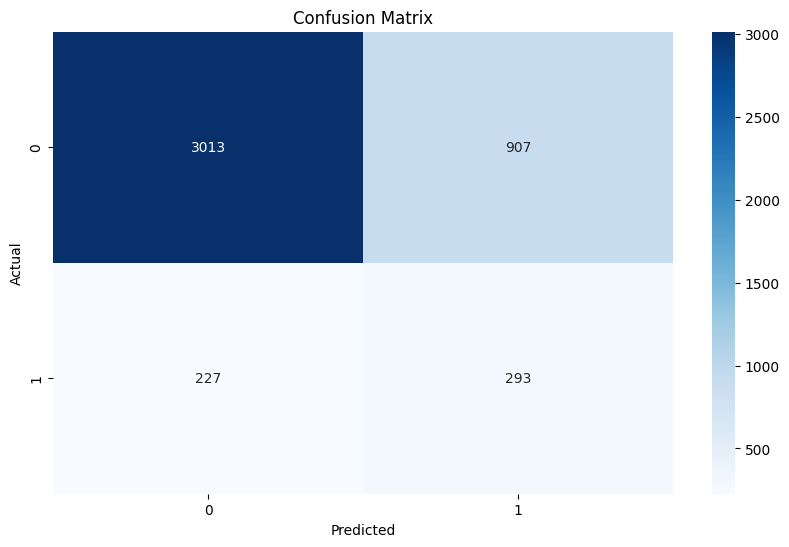

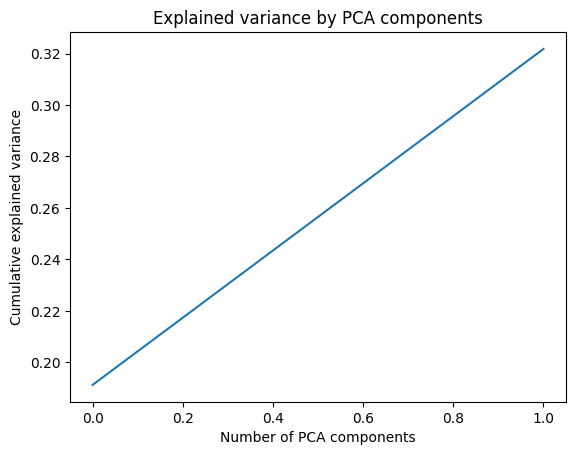

In [56]:
solver = LogisticRegressionClass_PCA(data=df_num, learning_rate=1e-5, epsilon=1e-5, max_iterations=1000, n_component=2)
solver.fit()

# Naive Bayes with PCA

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score, accuracy_score

#SVM utils
def visualize_svm(X, y, clf):
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(X[:,0], X[:,1], marker='o',c=y)

    x0_1 = np.amin(X[:,0])
    x0_2 = np.amax(X[:,0])

    x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
    x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

    x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

    ax.plot([x0_1, x0_2],[x1_1, x1_2], 'y--')
    ax.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'k')
    ax.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'k')

    x1_min = np.amin(X[:,1])
    x1_max = np.amax(X[:,1])
    ax.set_ylim([x1_min-3,x1_max+3])

    plt.show()




colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)


def generateBatchBipolar(n, mu=0.5, sigma=0.2):
    """ Two gaussian clouds on each side of the origin """
    X = np.random.normal(mu, sigma, (n, 2))
    yB = np.random.uniform(0, 1, n) > 0.5
    # y is in {-1, 1}
    y = 2. * yB - 1
    X *= y[:, np.newaxis]
    X -= X.mean(axis=0)
    return X, y

def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)


def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator',
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)

    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none',
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Plot margin
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

In [58]:
def pca( X, n_components=None):
  centered_X = X - np.mean(X, axis=0)
  cov_matrix = np.cov(centered_X, rowvar= False)

  eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

  sorted_indices = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[sorted_indices]
  eigenvectors = eigenvectors[:, sorted_indices]

  if n_components is not None:
    pca_components = eigenvectors[:, :n_components]
    variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
  else:
    pca_components = eigenvectors
    variance_ratio = eigenvalues / np.sum(eigenvalues)

  return pca_components, variance_ratio

In [59]:
nb_df = df_num.copy()
nb_df.loc[:,'y'] = nb_df['y'].replace({1: 1, 0: -1})
features_df = nb_df.drop(columns=['y'])
target_df = nb_df['y']

In [60]:
from sklearn.preprocessing import StandardScaler
X_train, testX, y_train, testy = train_test_split(features_df, target_df, test_size=0.2, random_state=42, stratify=target_df)

smote = SMOTE(random_state=23)
trainX, trainy = smote.fit_resample(X_train, y_train)

scaled_trainX = StandardScaler().fit_transform(trainX)

pca_components_trainX, _  = pca(scaled_trainX,n_components=2)

pca_trainX = np.dot(scaled_trainX, pca_components_trainX)

In [61]:
scaled_testX = StandardScaler().fit_transform(testX)

pca_components_testX, _  = pca(scaled_testX,n_components=2)

pca_testX = np.dot(scaled_testX, pca_components_testX)

# Naive Bayes

For Naive Bayes, we assume that all features are independent of each other, and numerical feature follows a Gaussian distribution.

In [62]:
@dataclass
class GaussianNaiveBayes:
  # def __init__(self, X, y) -> None:
  #   self.X=X
  #   self.y=y

  X_train: np.array
  y_train: np.array
  X_test: np.array
  y_test: np.array

  def __post_init__(self):
    self.X0_train = self.X_train[self.y_train == 0]
    self.X1_train = self.X_train[self.y_train == 1]
    self.y0_train = self.y_train[self.y_train == 0]
    self.y1_train = self.y_train[self.y_train == 1]
    self.fit()
    self.predict()

  def fit_distribution(self, x):
    mean = np.mean(x)
    std = np.std(x)
    dist = norm(mean,std)
    return dist

  def posterior(self, x, prior, dist_col1, dist_col2):
    return prior * dist_col1.pdf(x[0]) * dist_col2.pdf(x[1])

  def fit(self):
    self.prior_y0 = len(self.y0_train) / len(self.X_train)
    self.prior_y1 = len(self.y1_train) / len(self.X_train)

    self.dist_X_0_0 = self.fit_distribution(self.X0_train[:,0]) # Dist of Column 0 of Class 0
    self.dist_X_1_0 = self.fit_distribution(self.X0_train[:,1]) # Dist of Column 1 of Class 0

    self.dist_X_0_1 = self.fit_distribution(self.X1_train[:,0]) # Dist of Column 0 of Class 1
    self.dist_X_1_1 = self.fit_distribution(self.X1_train[:,1]) # Dist of Column 0 of Class 1

  def predict(self):
    predictions = []
    for sample, target in zip(self.X_test, self.y_test):
      py0 = self.posterior(sample, self.prior_y0, self.dist_X_0_0, self.dist_X_1_0 )
      py1 = self.posterior(sample, self.prior_y1, self.dist_X_0_1, self.dist_X_1_1 )
      predicted_class = np.argmax([py0, py1])
      predictions.append(predicted_class)
      # print('P(y=0 | %s) = %3.f' % (sample, py0 * 100))
      # print('P(y=1 | %s) = %3.f' % (sample, py1 * 100))

      # print("Model predicted class {} and the truth was: {} \n".format(np.argmax([py0*100, py1*100]), target))

    return np.array(predictions)

  def evaluate(self, testy, y_pred):
    accuracy = accuracy_score(testy, predictions)
    Error_rate = 1 - accuracy
    conf_matrix = confusion_matrix(testy, predictions)
    plt.figure(figsize=(10,6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    tn,fp,fn,tp = conf_matrix.ravel()

    Tnr = tn / (tn+fp)
    Fnr = fn / (fn+tp)

    precision = precision_score(testy, predictions)
    recall = recall_score(testy, predictions)
    f1 = f1_score(testy, predictions)
    metrics_df = pd.DataFrame({ "Metrics": ["Accuracy", "Error rate", "Sensitivity/Recall/True Positive Rate",
                                                "False Negative Rate", "Specificity/True Negative Rate", "F1 score"
                                               ],
                                   "Values": [accuracy, Error_rate, recall, Fnr,
                                             Tnr, f1
                                             ]

    })
    metrics_df.set_index("Metrics", inplace = True)
    display(metrics_df)

In [63]:
testy = np.where(testy == -1, 0 , testy)
trainy = np.where(trainy == -1, 0 , trainy)

In [64]:
nb = GaussianNaiveBayes(pca_trainX, trainy,pca_testX, testy)
predictions = nb.predict()

,Values
Metrics,
Accuracy,0.644820
Error rate,0.355180
Sensitivity/Recall/True Positive Rate,0.717308
False Negative Rate,0.282692
Specificity/True Negative Rate,0.635204
F1 score,0.321136


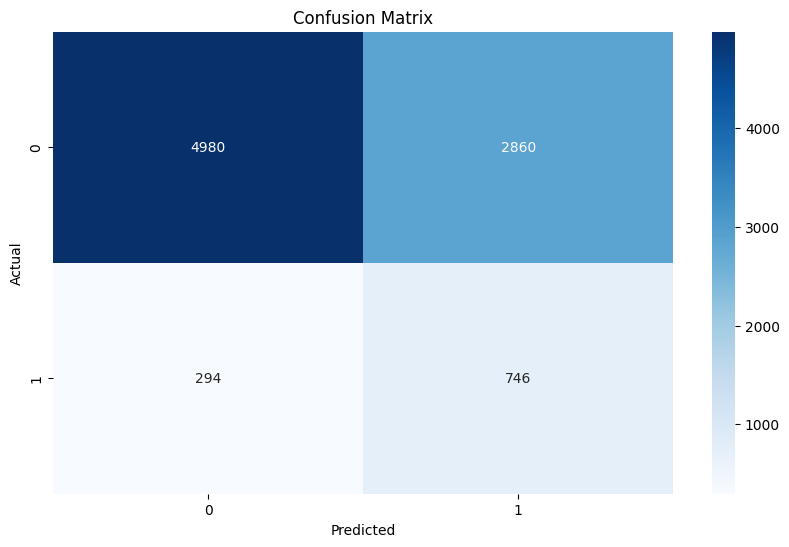

In [65]:
nb.evaluate(testy, predictions)